# Automated ARIMA forecasting with Python

Feng Li

School of Statistics and Mathematics

Central University of Finance and Economics

[feng.li@cufe.edu.cn](mailto:feng.li@cufe.edu.cn)

[https://feng.li/python](https://feng.li/python)

# ARIMA: Autoregressive Integrated Moving Average

This notebook provides an example of how to train an ARIMA model to generate point forecasts of product sales in retail. We will train an ARIMA based model on the Orange Juice dataset.

An ARIMA, which stands for AutoRegressive Integrated Moving Average, model can be created using an `ARIMA(p,d,q)` model within `statsmodels` library. In this notebook, we will be using an alternative library `pmdarima`, which allows us to automatically search for optimal ARIMA parameters, within a specified range. More specifically, we will be using `auto_arima` function within `pmdarima` to automatically discover the optimal parameters for an ARIMA model. This function wraps `ARIMA` and `SARIMAX` models of `statsmodels` library, that correspond to non-seasonal and seasonal model space, respectively.

- In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are:
    - **p** is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
    - **d** is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
    - **q** is the parameter associated with the moving average part of the model.,

- If our data has a seasonal component, we use a seasonal ARIMA model or `ARIMA(p,d,q)(P,D,Q)m`. In that case, we have an additional set of parameters: `P`, `D`, and `Q` which describe the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model, and `m` refers to the number of periods in each season.


In [1]:
! pip3 install pmdarima --user

Looking in indexes: https://mirrors.163.com/pypi/simple/


## Global Settings and Imports

In [2]:
import os
import sys
import math
import warnings
import itertools
import numpy as np
import pandas as pd
# import scrapbook as sb
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

print("System version: {}".format(sys.version))

System version: 3.9.7 (default, Sep 24 2021, 09:43:00) 
[GCC 10.3.0]


## Parameters

Next, we define global settings related to the model. We will use historical weekly sales data only, without any covariate features to train the ARIMA model. The model parameter ranges are provided in params. These are later used by the `auto_arima()` function to search the space for the optimal set of parameters. To increase the space of models to search over, increase the `max_p` and `max_q` parameters.

> NOTE: Our data does not show a strong seasonal component (as demonstrated in data exploration example notebook), so we will not be searching over the seasonal ARIMA models. To search over the seasonal models, set `seasonal` to `True` and include `start_P`, `start_Q`, `max_P`, and `max_Q` parameters in the auto_arima() function.

In [29]:
# Forecasting settings
N_SPLITS = 1
HORIZON = 2
GAP = 2
FIRST_WEEK = 40
LAST_WEEK = 138

# Parameters of ARIMA model
params = {
    "seasonal": False,
    "start_p": 0,
    "start_q": 0,
    "max_p": 5,
    "max_q": 5,
    "m": 52,
}

## Data Preparation


- We store the training data and test data using dataframes. 

    - `train_df` contains the historical sales up to week 135 (the time we make forecasts) 
    - `aux_df` containing price/promotion information up until week 138. Here we assume that future price and promotion information up to a certain number of weeks ahead is predetermined and known. 


    
- In our example, we will be using historical sales only, and will not be using the `aux_df` data. The test data is stored in `test_df` which contains the sales of each product in week 137 and 138. 

- Assuming the current week is week 135, our goal is to forecast the sales in week 137 and 138 using the training data. There is a one-week gap between the current week and the first target week of forecasting as we want to leave time for planning inventory in practice.

In [4]:
train_df = pd.read_csv("data/OrangeJuice_train.csv")
test_df = pd.read_csv("data/OrangeJuice_test.csv")

### Process training data

Our time series data is not complete, since we have missing sales for some stores/products and weeks. We will fill in those missing values by propagating the last valid observation forward to next available value. We will define functions for data frame processing, then use these functions within a loop that loops over each forecasting rounds.

Note that our time series are grouped by `store` and `brand`, while `week` represents a time step, and `logmove` represents the value to predict.

Let's first process the training data. Note that the training data runs from `FIRST_WEEK` to `LAST_WEEK - HORIZON - GAP + 1` as defined in Parameters section above.

In [5]:
# Select only required columns
train_df = train_df[["store", "brand", "week", "logmove"]]
train_df

,store,brand,week,logmove
0,2,1,40,9.02
1,2,1,46,8.72
2,2,1,47,8.25
3,2,1,48,8.99
4,2,1,50,9.09
...,...,...,...,...
84178,137,11,131,9.63
84179,137,11,132,9.70
84180,137,11,133,9.00
84181,137,11,134,8.91


Notice that the unit sales of the products are given in logarithmic scale. We will use this quantity for training the forecasting model, as it smooths out the time series, and results in better forecasting performance. We will convert the `logmove` to a unit scale for evaluation, for consistency across our examples.

In [9]:
def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists."""
    from itertools import product

    cart = list(product(*dict_in.values()))
    df = pd.DataFrame(cart, columns=dict_in.keys())
    return df

def complete_and_fill_df(df, stores, brands, weeks):
    """Completes missing rows in Orange Juice datasets and fills in the missing values.
    """
    d = {"store": stores, "brand": brands, "week": weeks}
    data_grid = df_from_cartesian_product(d)
    # Complete all rows
    df_filled = pd.merge(data_grid, df, how="left", on=["store", "brand", "week"])
    # Fill in missing values
    df_filled = df_filled.groupby(["store", "brand"]).apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
    return df_filled

In [11]:
# Create a dataframe to hold all necessary data
store_list = train_df["store"].unique()
brand_list = train_df["brand"].unique()
train_week_list = range(FIRST_WEEK, LAST_WEEK - (HORIZON - 1) - (GAP - 1))

train_filled = complete_and_fill_df(train_df, stores=store_list, brands=brand_list, weeks=train_week_list)
train_filled

,store,brand,week,logmove
0,2,1,40,9.02
1,2,1,41,9.02
2,2,1,42,9.02
3,2,1,43,9.02
4,2,1,44,9.02
...,...,...,...,...
87643,137,11,131,9.63
87644,137,11,132,9.70
87645,137,11,133,9.00
87646,137,11,134,8.91


### Process test data

Let's now process the test data. Note that the test data runs from `LAST_WEEK - HORIZON + 1` to `LAST_WEEK`. Note that, in addition to filling out missing values, we also convert unit sales from logarithmic scale to the counts. We will do model training on the log scale, due to improved performance, however, we will transfrom the test data back into the unit scale (counts) by applying `math.exp()`, so that we can evaluate the performance on the unit scale.

In [12]:
# Evaluate prediction accuracy
test_df["actuals"] = test_df.logmove.apply(lambda x: round(math.exp(x)))
test_df = test_df[["store", "brand", "week", "actuals"]]

test_week_list = range(LAST_WEEK - HORIZON + 1, LAST_WEEK + 1)
test_filled = complete_and_fill_df(test_df, stores=store_list, brands=brand_list, weeks=test_week_list)

test_filled

,store,brand,week,actuals
0,2,1,137,9792
1,2,1,138,16960
2,2,2,137,6240
3,2,2,138,14784
4,2,3,137,1920
...,...,...,...,...
1821,137,9,138,384
1822,137,10,137,40384
1823,137,10,138,7232
1824,137,11,137,7424


## Model training

We next train an ARIMA model for a single time series, for demonstration. We select `STORE=2` and `BRAND=6` and filter our data based on these values.

In [13]:
STORE = 2
BRAND = 6

train_ts = train_filled.loc[(train_filled.store == STORE) & (train_filled.brand == BRAND)]
train_ts.tail(10)

,store,brand,week,logmove
566,2,6,126,8.52
567,2,6,127,8.03
568,2,6,128,8.15
569,2,6,129,8.03
570,2,6,130,7.74
571,2,6,131,7.45
572,2,6,132,7.70
573,2,6,133,7.93
574,2,6,134,7.27
575,2,6,135,6.96


In [14]:
train_ts = np.array(train_ts.logmove)

model = auto_arima(
    train_ts,
    seasonal=params["seasonal"],
    start_p=params["start_p"],
    start_q=params["start_q"],
    max_p=params["max_p"],
    max_q=params["max_q"],
    stepwise=True,
)

model.fit(train_ts)

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

Let's look at the model summary. As seen from the summary, the selected ARIMA model is `(p=1, d=0, q=0)`. This is a relatively simple model, also referred to as first-order auto-regressive model. It indicates that the time series is stationary and can be predicted as a multiple of its own previous value, plus a constant.  This is an `ARIMA(1,0,0)+constant` model.

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -18.335
Date:                Fri, 12 Nov 2021   AIC                             42.670
Time:                        12:27:01   BIC                             50.363
Sample:                             0   HQIC                            45.779
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5490      0.686      5.172      0.000       2.204       4.894
ar.L1          0.5579      0.086      6.468      0.000       0.389       0.727
sigma2         0.0855      0.012      6.973      0.000       0.061       0.109
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.64   Prob(JB):                         0.50
Heteroskedasticity (H):               1.48   Skew:                            -0.28
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model summary contains a lot of information. The coefficient table in the middle provides the estimates for the weights of the respective p and q terms. Notice that the coefficient of the AR1 term has a low p-value (`P>|z|` column), indicating that this term is significant. It also shows that the constant term is significant with a low p-value.

Next, let's also examine the diagnostics plot for the selected model.

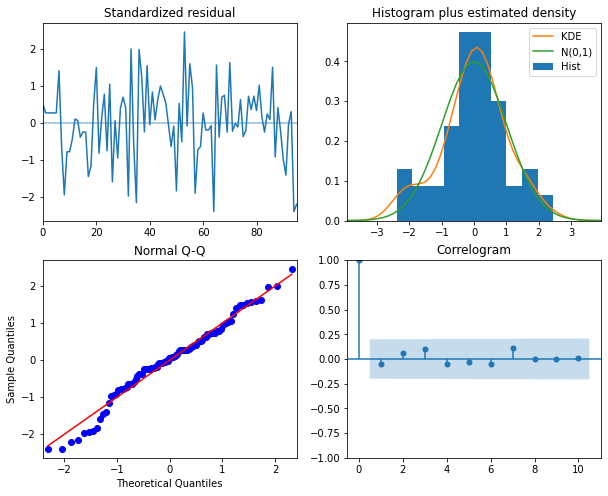

In [16]:
model.plot_diagnostics(figsize=(10, 8))
plt.show()

In the top left, the residual errors fluctuate around a mean of zero and have a uniform variance, which may indicate that there is no bias in prediction. The density plot in the top right suggests normal distribution with mean zero.

The Correlogram, or the ACF plot, in the lower right shows the residual errors are not autocorrelated. Any detected autocorrelation in this plot suggests that there may be some pattern in the residual errors which are not explained in the model, so adding additional predictors to the model may be beneficial.



In the bottom left, we do not see significant deviation of residuals from the red line, which indicates that the model is a good fit.

Overall, based on the above, it seems to that the model is a good fit for this data.


It is worth noting that selecting the best parameters for an ARIMA model can be challenging - somewhat subjective and time intesive, and should be done following a thorough data examination (seasonality, trend, bias). We use an `auto_arima()` function to search a provided space of parameters for the best model, mostly to demonstrate its usage and functionality.


## Model evaluation

Let's now take a look at the predictions. Since auto_arima model makes consecutive forecasts from the last time point, we want to forecast the next `n_periods = GAP + HORIZON - 1` points, so that we can account for the GAP, as described in the data setup. As mentioned above, we are also transforming our predictions from logarithmic scale to counts, for calculating evaluation metric.

In [17]:
preds = model.predict(n_periods=GAP + HORIZON - 1)

predictions = np.round(np.exp(preds[-HORIZON:]))
pred_df = pd.DataFrame({"predictions": predictions, "store": STORE, "brand": BRAND, "week": test_week_list})

pred_df

,predictions,store,brand,week
0,"2,199.00",2,6,137
1,"2,546.00",2,6,138


To evaluate the model, we will use *mean absolute percentage error* or **MAPE**.

In [18]:
# Combine actual units and predictions
test_ts = test_filled.loc[(test_filled.store == STORE) & (test_filled.brand == BRAND)]

combined = pd.merge(pred_df, test_ts, on=["store", "brand", "week"], how="left")
combined

,predictions,store,brand,week,actuals
0,"2,199.00",2,6,137,5760
1,"2,546.00",2,6,138,1440


In [20]:
def MAPE(predictions, actuals):
    """
    Implements Mean Absolute Percent Error (MAPE).

    Args:
        predictions (array like): a vector of predicted values.
        actuals (array like): a vector of actual values.

    Returns:
        numpy.float: MAPE value
    """
    if not (isinstance(actuals, pd.Series) and isinstance(predictions, pd.Series)):
        predictions, actuals = pd.Series(predictions), pd.Series(actuals)

    return ((predictions - actuals).abs() / actuals).mean()

In [21]:
metric_value = MAPE(combined.predictions, combined.actuals) * 100

print(f"MAPE of the forecasts is {metric_value}%")

MAPE of the forecasts is 69.31423611111111%


## Model training for all stores and brands

Now let's run model training across all the stores and brands. We will re-run the same code to automatically search for the best parameters, simply wrapped in a for loop iterating over stores and brands.

In [22]:
def train_store_brand(data, store, brand):
    train_ts = data.loc[(data.store == store) & (data.brand == brand)]
    train_ts = np.array(train_ts["logmove"])

    model = auto_arima(
        train_ts,
        seasonal=params["seasonal"],
        start_p=params["start_p"],
        start_q=params["start_q"],
        max_p=params["max_p"],
        max_q=params["max_q"],
        stepwise=True,
        error_action="ignore",
    )

    model.fit(train_ts)
    preds = model.predict(n_periods=GAP + HORIZON - 1)
    predictions = np.round(np.exp(preds[-HORIZON:]))

    pred_df = pd.DataFrame({"predictions": predictions, "store": store, "brand": brand, "week": test_week_list})
    test_ts = test_filled.loc[(test_filled.store == store) & (test_filled.brand == brand)]

    return pd.merge(pred_df, test_ts, on=["store", "brand", "week"], how="left")

In [24]:
%%time
    
from datetime import datetime
    
# Just train a few stores to save time
store_list = store_list[0:3]

result_df = pd.DataFrame(None, columns=["predictions", "store", "brand", "week", "actuals"])

print("Training ARIMA model...")
for store, brand in itertools.product(store_list, brand_list):
    if brand == 1:
        print(f"{datetime.now().time()} - Forecasting for store: {store}")

    combined_df = train_store_brand(train_filled, store, brand)
    result_df = result_df.append(combined_df, ignore_index=True)

Training ARIMA model...
12:29:25.881911 - Forecasting for store: 2
12:29:44.320624 - Forecasting for store: 5
12:29:55.796922 - Forecasting for store: 8
CPU times: user 2min 31s, sys: 6.6 s, total: 2min 38s
Wall time: 40.4 s


Let's compute `MAPE` for all predictions.

In [25]:
metric_value

69.31423611111111

In [26]:
metric_value = MAPE(result_df.predictions, result_df.actuals) * 100
# sb.glue("MAPE", metric_value)

print(f"MAPE of the forecasts is {metric_value} %")

MAPE of the forecasts is 68.78729124622176 %


When building a model with `auto_arima` for a large number of time series, it is often difficult to examine each model individually (in a similar way we did for the single time series above). As `auto_arima` searches a restricted space of the models, defined by the range of `p` and `q` parameters, we often might not find an optimal model for each time series.

Let's plot a few examples of forecasted results.

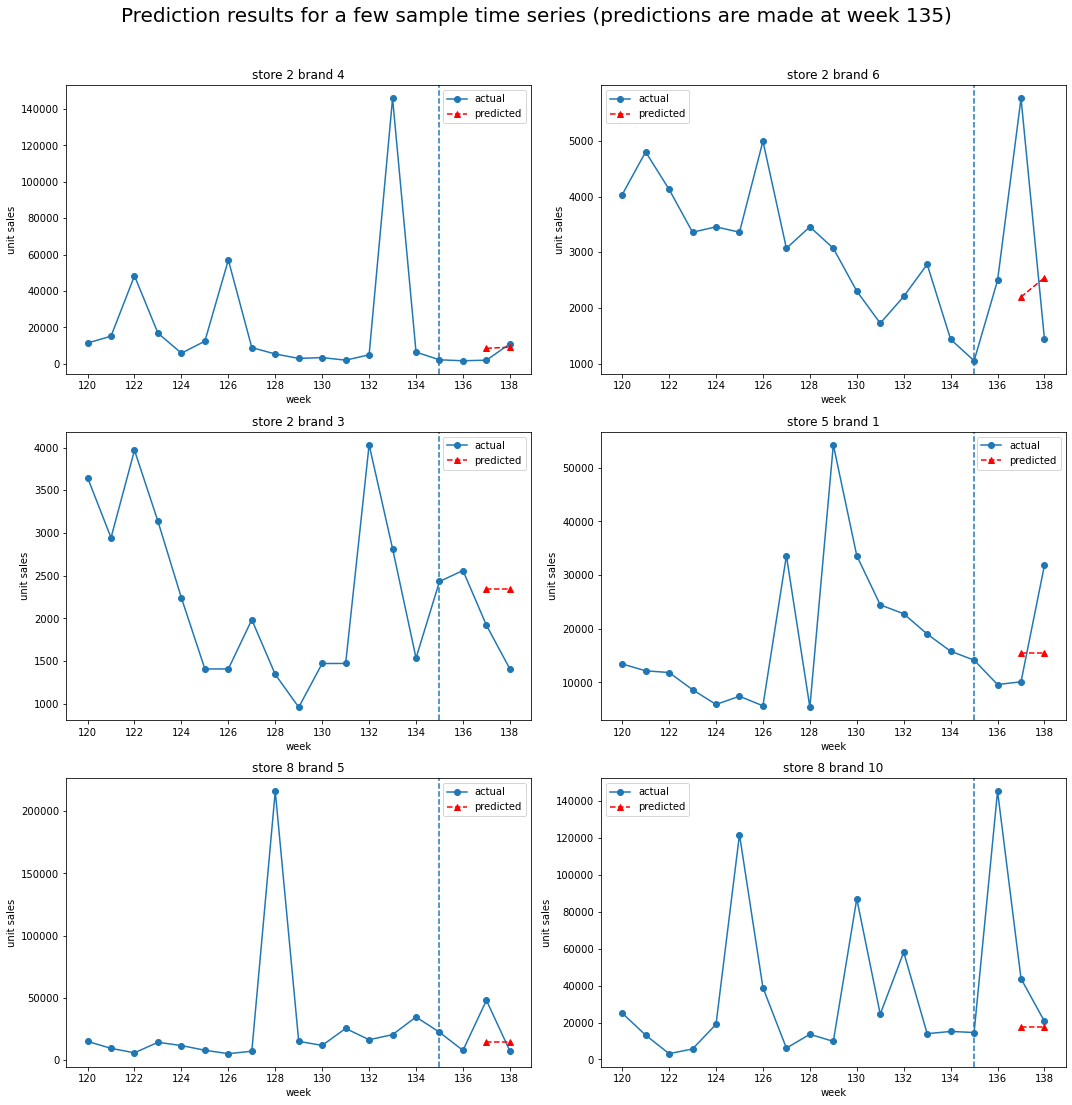

In [28]:
num_samples = 6
min_week = 120
sales = pd.read_csv("data/yx.csv")
sales["move"] = sales.logmove.apply(lambda x: round(math.exp(x)) if x > 0 else 0)

result_df["move"] = result_df.predictions
from data.plot import plot_predictions_with_history

plot_predictions_with_history(
    result_df,
    sales,
    grain1_unique_vals=store_list,
    grain2_unique_vals=brand_list,
    time_col_name="week",
    target_col_name="move",
    grain1_name="store",
    grain2_name="brand",
    min_timestep=min_week,
    num_samples=num_samples,
    predict_at_timestep=max(train_df.week),
    line_at_predict_time=True,
    title="Prediction results for a few sample time series (predictions are made at week 135)",
    x_label="week",
    y_label="unit sales",
    random_seed=2,
)

## Additional Reading

- Rob J Hyndman and George Athanasopoulos. 2018. Forecasting: Principles and Practice. Chapter 8 ARIMA models: https://otexts.com/fpp2/arima.html


- Hyndman, R.J., & Athanasopoulos, G.著. 预测：方法与实践（第2版），康雁飞、李丰（译) https://otexts.com/fppcn/arima-cn.html